# VIS/NIR Tutorial 

For dual VIS/NIR workflows, a visible image is used to identify an image mask for the plant material.
The get nir function is used to get the NIR image that matches the VIS image (must be in same folder,
with similar naming scheme), then functions are used to size and place the VIS image mask over the NIR image.
This allows two workflows to be done at once and also allows plant material to be identified in low-quality images.
We do not recommend this approach if there is a lot of plant movement between capture of NIR and VIS images.

To run a VIS/NIR workflow over a single VIS image there are two required inputs:

1.  **Image:** Images can be processed regardless of what type of VIS camera was used (high-throughput platform, digital camera, cell phone camera).
Image processing will work with adjustments if images are well lit and free of background that is similar in color to plant material.  
2.  **Output directory:** If debug mode is set to 'print' output images from each intermediate step are produced.


In [1]:
# Import Libraries 
import cv2
from plantcv import plantcv as pcv


In [2]:
class options:
    def __init__(self):
        self.image = "../img/tutorial_images/vis_nir/VIS_SV_image.jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "vis_nir_tutorial_results.json"
        self.outdir = "." # Store the output to the current directory

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug


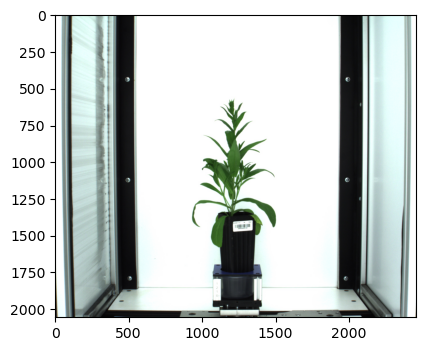

In [3]:
# Read image 

# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv' 
img, path, filename = pcv.readimage(filename=args.image)



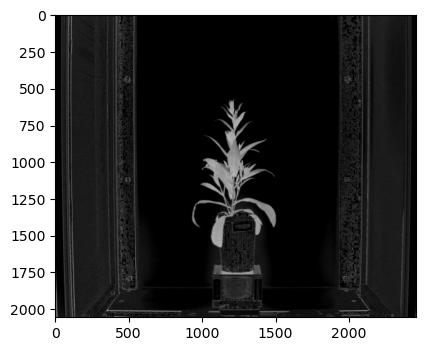

In [4]:
# Convert RGB to HSV and extract the saturation channel

# Inputs:
#   rgb_img - RGB image data 
#   channel - Split by 'h' (hue), 's' (saturation), or 'v' (value) channel
s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')


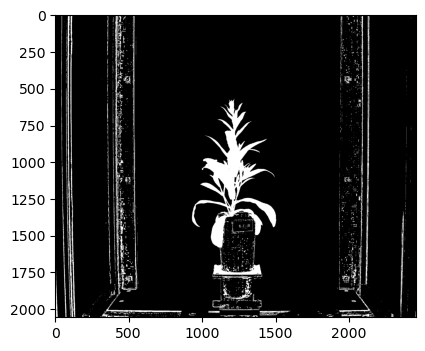

In [5]:
# Threshold the Saturation image

# Inputs:
#   gray_img - Grayscale image data 
#   threshold- Threshold value (between 0-255)
#   max_value - Value to apply above threshold (255 = white) 
#   object_type - 'light' (default) or 'dark'. If the object is lighter than the background then standard threshold is done.
#                 If the object is darker than the background then inverse thresholding is done. 
s_thresh = pcv.threshold.binary(gray_img=s, threshold=50, max_value=255, object_type='light')



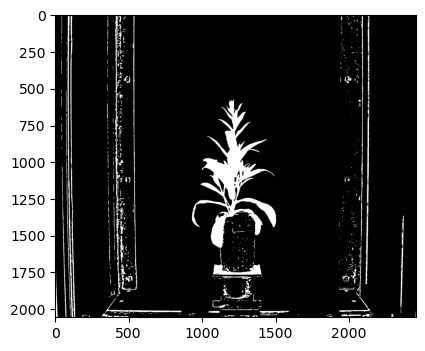

In [6]:
# Median Blur

# Inputs: 
#   gray_img - Grayscale image data 
#   ksize - Kernel size (integer or tuple), (ksize, ksize) box if integer input,
#           (n, m) box if tuple input 
s_mblur = pcv.median_blur(gray_img=s_thresh, ksize=5)


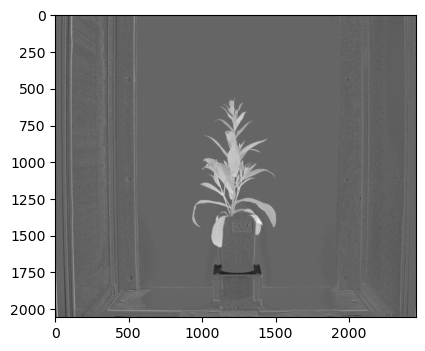

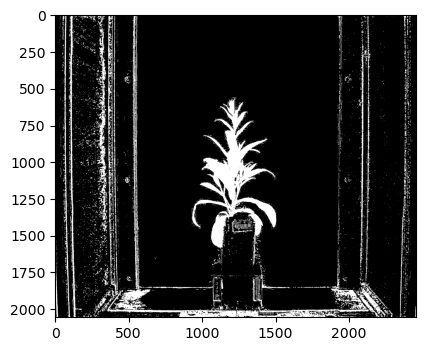

In [7]:
# Convert RGB to LAB and extract the blue-yellow channel

# Input:
#   rgb_img - RGB image data 
#   channel- Split by 'l' (lightness), 'a' (green-magenta), or 'b' (blue-yellow) channel
b = pcv.rgb2gray_lab(rgb_img=img, channel='b')

# Threshold the blue-yellow channel image
b_thresh = pcv.threshold.binary(gray_img=b, threshold=129, max_value=255, object_type='light')


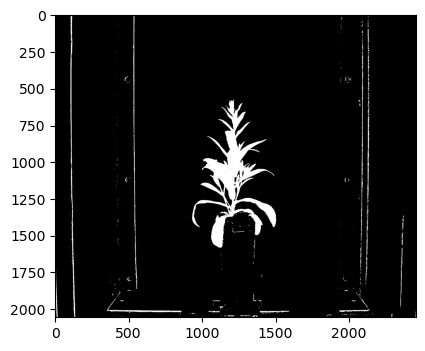

In [8]:
# Join the thresholded saturation and blue-yellow images

# Inputs: 
#   bin_img1 - Binary image data to be compared to bin_img2
#   bin_img2 - Binary image data to be compared to bin_img1
bs = pcv.logical_and(bin_img1=s_mblur, bin_img2=b_thresh)


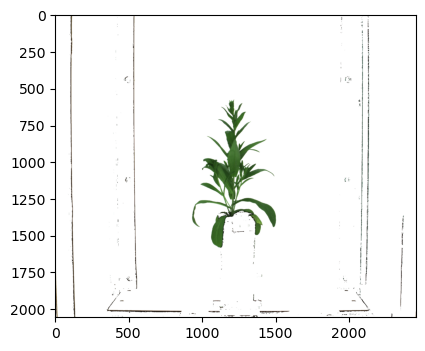

In [9]:
# Apply Mask

# Inputs:
#   img - RGB or grayscale image data 
#   mask - Binary mask image data 
#   mask_color - 'white' or 'black' 
masked = pcv.apply_mask(img=img, mask=bs, mask_color='white')


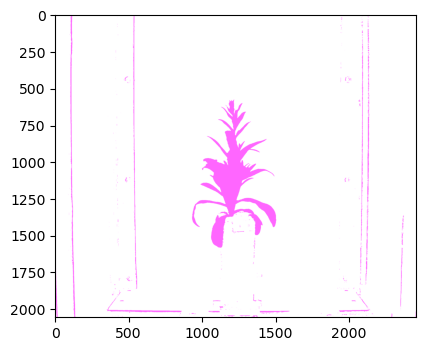

In [10]:
# Identify objects

# Inputs: 
#   img - RGB or grayscale image data for plotting 
#   mask - Binary mask used for detecting contours 
id_objects,obj_hierarchy = pcv.find_objects(img=masked, mask=bs)


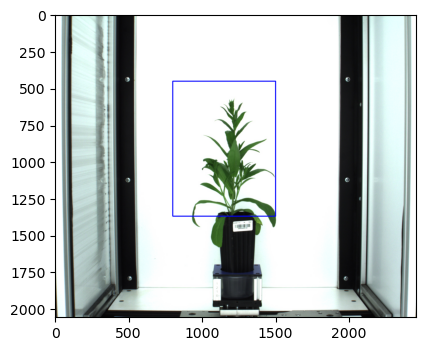

In [11]:
# Define Region of Interest (ROI) 

# Inputs: 
#   img - RGB or grayscale image to plot the ROI on 
#   x - The x-coordinate of the upper left corner of the rectangle 
#   y - The y-coordinate of the upper left corner of the rectangle 
#   h - The height of the rectangle 
#   w - The width of the rectangle 
roi1, roi_hierarchy = pcv.roi.rectangle(img=img, x=800, y=450, h=920, w=700)


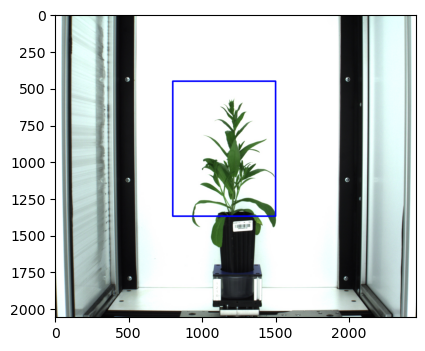

In [12]:
# This image is relatively large, and it's making it so not all sides of the ROI are showing up 
# when plotted in Jupyter. There is an optional line_thickness parameter in the params class.
# Default line_thickness = 5. 
pcv.params.line_thickness = 10
roi1, roi_hierarchy = pcv.roi.rectangle(img=img, x=800, y=450, h=920, w=700)


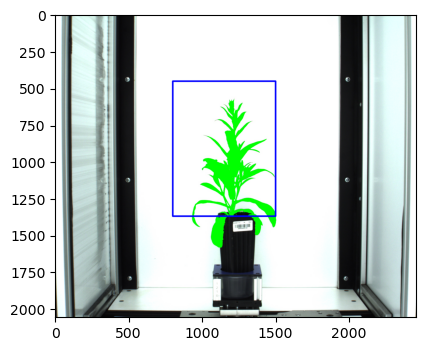

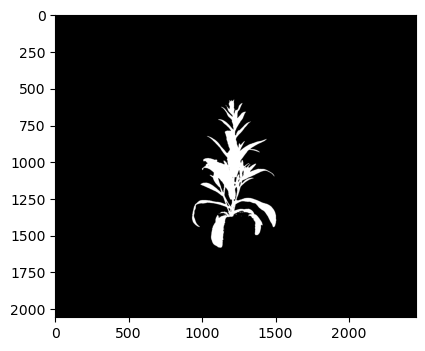

In [13]:
# Decide which objects to keep

# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from pcv.find_objects function
#    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)
roi_objects, hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi1, 
                                                              roi_hierarchy=roi_hierarchy,
                                                              object_contour=id_objects,
                                                              obj_hierarchy=obj_hierarchy,
                                                              roi_type='partial')


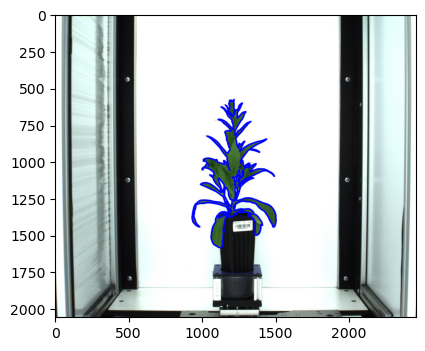

In [14]:
# Object combine the kept objects

# Inputs:
#   img - RGB or grayscale image data for plotting 
#   contours - Contour list 
#   hierarchy - Contour hierarchy array 
obj, mask = pcv.object_composition(img=img, contours=roi_objects, hierarchy=hierarchy)


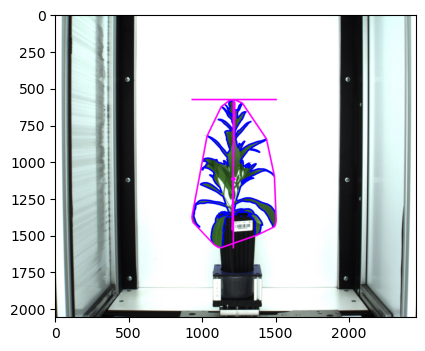

In [15]:
############### Analysis ################  
  
# Find shape properties

# Inputs:
#   img - RGB or grayscale image data 
#   obj- Single or grouped contour object
#   mask - Binary image mask to use as mask for moments analysis 
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

analysis_image = pcv.analyze_object(img=img, obj=obj, mask=mask, label="VIS")


/Users/nfahlgren/miniconda3/envs/plantcv/lib/python3.7/site-packages/plantcv-3.12.1+254.gf594e7ee.dirty-py3.7.egg/plantcv/plantcv/acute_vertex.py:91: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


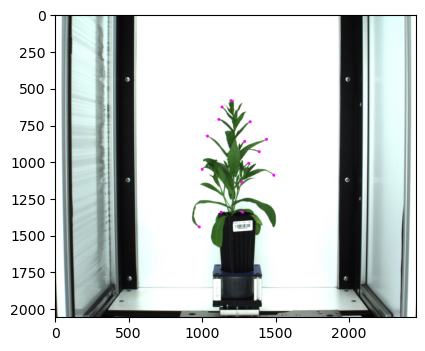

In [16]:
# Search for accute vertices 

# Inputs:
#   img - RGB or grayscale image 
#   obj - A contour of the plant object 
#   win - The pre and post point distances on which to calculate 
#            the angle of the focal point on which to calculate 
#            the angle
#   thresh - Threshold to set for acuteness
#   sep - The number of contour points to search within for the 
#         most acute value 
#   label -Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

acute_points_list = pcv.acute_vertex(img=img, obj=obj, win=30, thresh=25, sep=100, label="VIS")


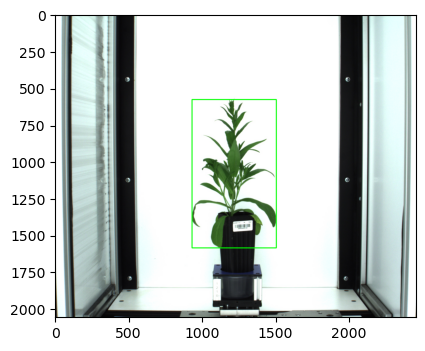

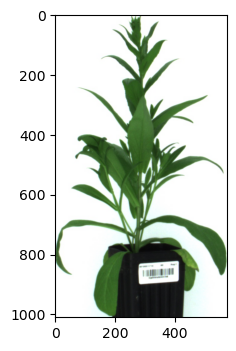

In [17]:
# You can automatically crop an image to a contour 

# Inputs: 
#   img - RGB or grayscale image data
#   obj - Contour of target object 
#   padding_x - Padding in the x direction (default padding_x=0)
#   padding_y - Padding in the y direction (default padding_y=0)
#   color - Either 'black' (default), 'white', or 'image' 
cropped_img = pcv.auto_crop(img=img, obj=obj)


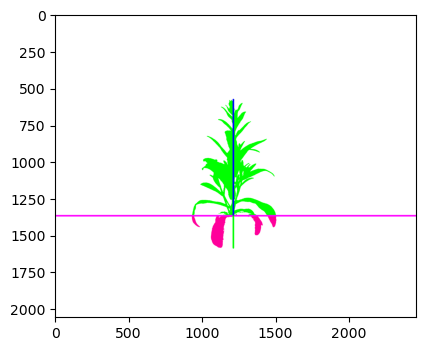

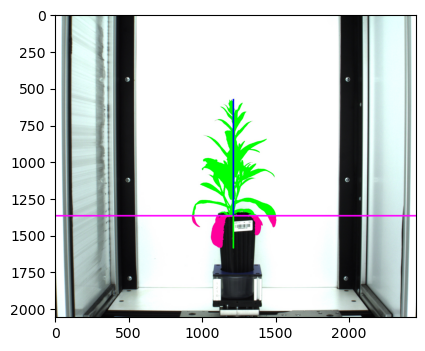

In [18]:
# Shape properties relative to user boundary line 

# Inputs:
#   img - RGB or grayscale image data 
#   obj - Single or grouped contour object 
#   mask - Binary mask of selected contours 
#   line_position - Position of boundary line (a value of 0 would draw a line 
#                   through the bottom of the image) 
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

boundary_images_h = pcv.analyze_bound_horizontal(img=img, obj=obj, mask=mask, 
                                                 line_position=1370, label="VIS")


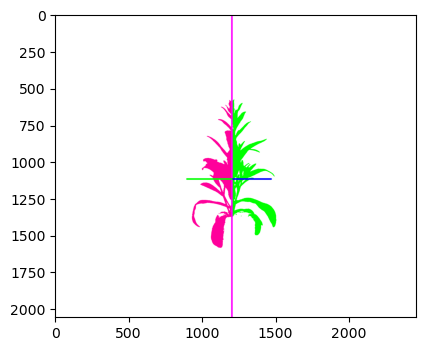

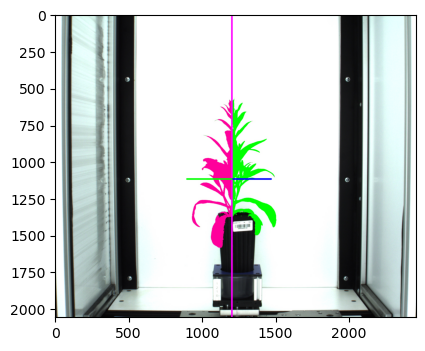

In [19]:
# Inputs:
#   img - RGB or grayscale image data 
#   obj - Single or grouped contour object 
#   mask - Binary mask of selected contours 
#   line_position - Position of boundary line (a value of 0 would draw a line 
#                   through the left of the image) 
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

boundary_images_v = pcv.analyze_bound_vertical(img=img, obj=obj, mask=mask, 
                                               line_position=1200, label="VIS")


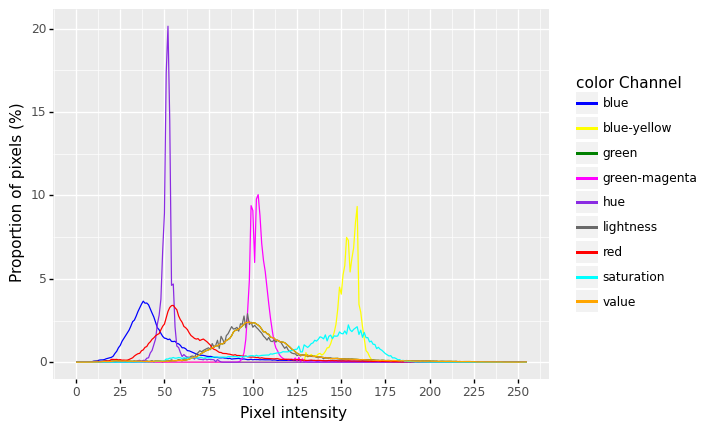

In [20]:
# Determine color properties

# Inputs:
#   rgb_img - RGB image data
#   mask - Binary mask of selected contours 
#   hist_plot_type - None (default), 'all', 'rgb', 'lab', or 'hsv'
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

color_histogram = pcv.analyze_color(rgb_img=img, mask=kept_mask, hist_plot_type='all', label="VIS")



The next steps are to get the matching NIR image, resize, and place the VIS mask over it. 

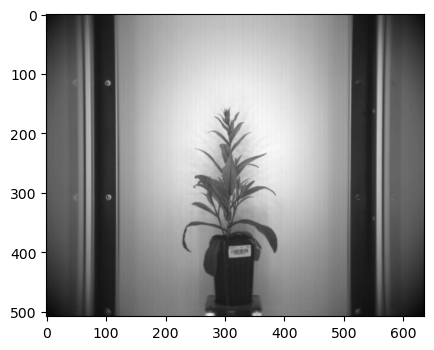

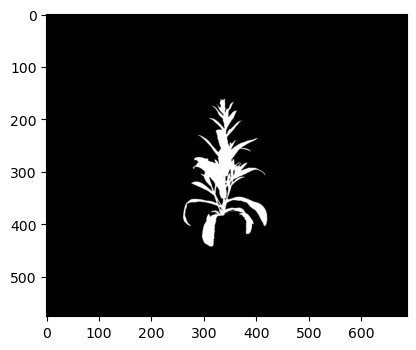

In [21]:
nirpath = pcv.get_nir(path,filename)
nir, path1, filename1 = pcv.readimage(nirpath, mode='gray')

# Inputs:
#   img - RGB or grayscale image to resize
#   factors - Resizing factors (width, height). E.g. (0.5, 0.5)
#   interpolation - Interpolation method. Available options are "auto" = select method automatically (default), 
#   "area" = resampling using pixel area (OpenCV INTER_AREA), "bicubic" = bicubic interpolation (OpenCV INTER_CUBIC), 
#   "bilinear" = bilinear interpolation (OpenCV INTER_LINEAR), "lanczos" = Lanczos interpolation (OpenCV 
#   INTER_LANCZOS4), "nearest" = nearest-neighbor interpolation (OpenCV INTER_NEAREST).
nmask = pcv.transform.resize_factor(img=mask, factors=(0.28, 0.28))




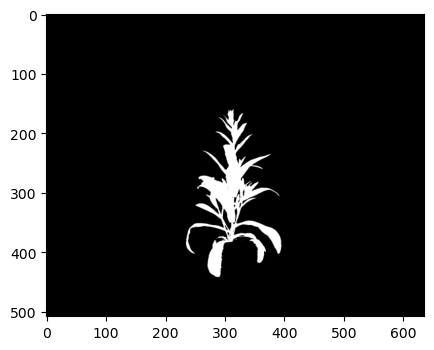

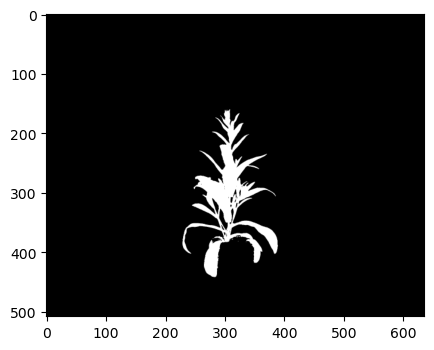

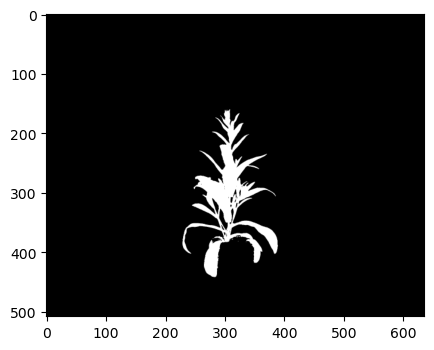

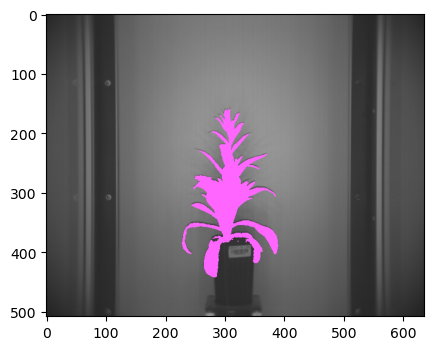

In [22]:
# Inputs:
#   img - RGB or grayscale image data 
#   mask - Binary image to be used as a mask 
#   x - Amount to push in the vertical direction
#   y - Amount to push in the horizontal direction
#   v_pos - Push from the 'top' (default) or 'bottom' in the vertical direction
#   h_pos - Push from the 'right' (default) or 'left' in the horizontal direction 
newmask = pcv.crop_position_mask(img=nir, mask=nmask, x=34, y=7, 
                                 v_pos="top", h_pos="right")


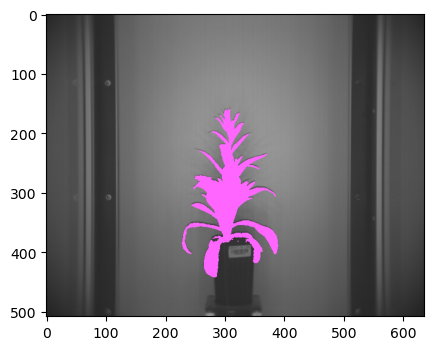

In [23]:
# Find objects in the new mask 
nir_objects, nir_hierarchy = pcv.find_objects(img=nir, mask=newmask)


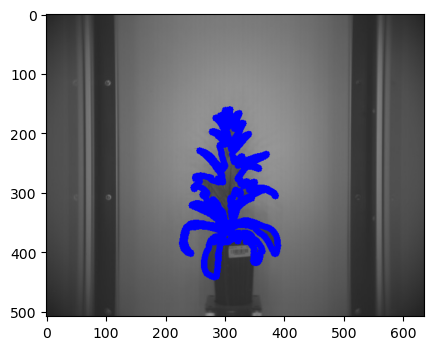

In [24]:
# Combine objects
nir_combined, nir_combinedmask = pcv.object_composition(img=nir, contours=nir_objects, 
                                                        hierarchy=nir_hierarchy)


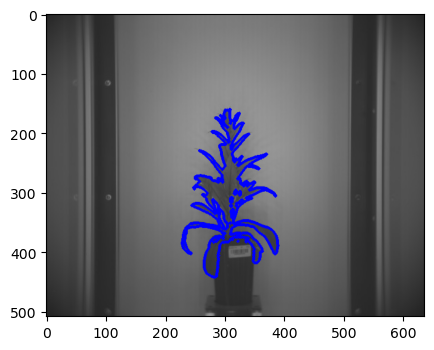

In [25]:
# This image is relatively small now, and the lines drawn are too thick 
# when plotted in Jupyter. There is an optional line_thickness parameter in the params class.
# Default line_thickness = 5. 
pcv.params.line_thickness = 3

nir_combined, nir_combinedmask = pcv.object_composition(img=nir, contours=nir_objects, 
                                                        hierarchy=nir_hierarchy)


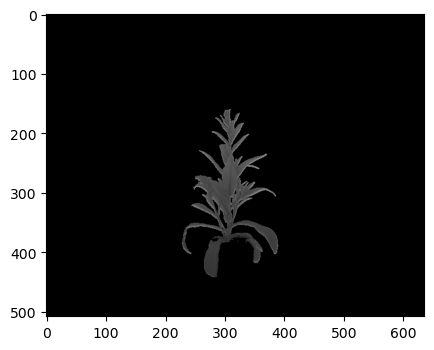

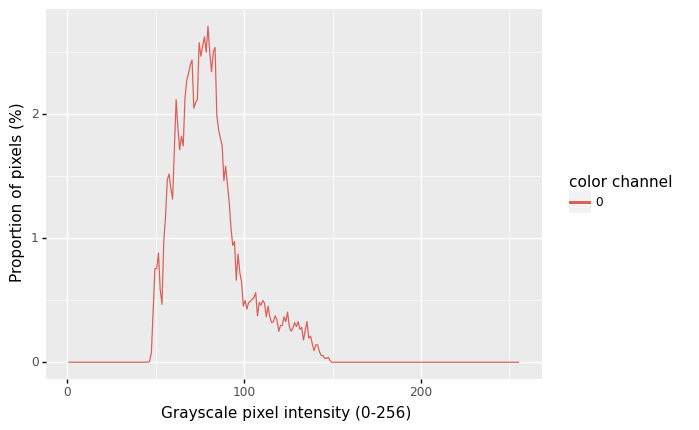

In [26]:
# Analyze the NIR intensity 

# Inputs: 
#   gray_img - 8 or 16-bit grayscale image data 
#   mask - Binary mask made from selected contours 
#   bins - Number of classes to divide spectrum into
#   histplot - If True then plots histogram of intensity values, (default False) 
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

nir_hist = pcv.analyze_nir_intensity(gray_img=nir, mask=nir_combinedmask, 
                                     bins=256, label="NIR")

# Print out the nir histogram to save it.  
pcv.print_image(img=nir_hist, filename='vis_nir_tutorial_nir_hist.jpg')


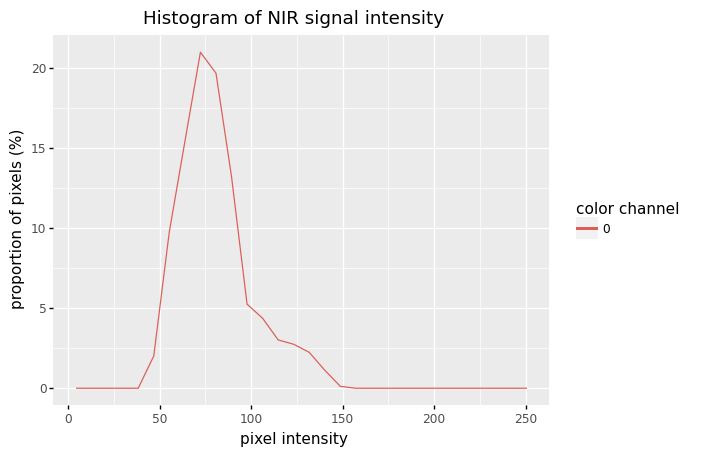

In [27]:
# Plot a histogram of NIR signal intensity
nir_hist = pcv.visualize.histogram(img=nir, mask=nir_combinedmask, lower_bound=0, upper_bound=255, bins=30, title="Histogram of NIR signal intensity")

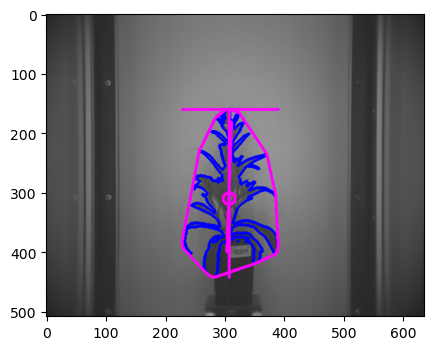

In [28]:
# Analyze the shape of the object 
nir_images = pcv.analyze_object(img=nir, obj=nir_combined, mask=nir_combinedmask, label="NIR")


In [29]:
# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object, 
# fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file 
pcv.outputs.save_results(filename=args.result)


To view and/or download the text file output (saved in JSON format)...
1) To see the text file with data that got saved out, click “File” tab in top left corner.
2) Click “Open…”
3) Open the file named “vis_nir_tutorial_results.txt”

Check out documentation on how to [convert JSON](https://plantcv.readthedocs.io/en/latest/tools/#convert-output-json-data-files-to-csv-tables) format output into table formatted output. Depending on the analysis steps a PlantCV user may have two CSV files (single value traits and multivalue traits). 
